In [58]:
import pandas as pd
import numpy as np
from functools import reduce, partial
from copy import deepcopy
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

pd.set_option('display.max_rows', 50)

### How to use the simulator. 

First choose what you want your LOW_PERC, UP_PERC and TIMELAGS to be.

- **LOW_PERC** is the minimum percentage charged to the restaurant. It will increase up to the upper bount every 0.001.
- **UP_PERC** is the highest percentage charged to the restaurant. It had to always include  0.001 extra (you want the highest to be 0.03 => type here 0.031).
- **TIMELAGS** is the range of timelags you want to test. If you want 2, 3, 4, 5 then your range is from 2 to 6. 

Then customize the **SCENARIO_BASE** data. Abbreviations are provided.

Finally click `SHIFT+ENTER` to run a cell, do so until the end. 

In [59]:
# constants

# 6 days a week, 4 week a month, 11 months a year.
YEAR_WORK_DAYS = 6 * 4 * 11.5  

# customize the below to your liking.
LOW_PERC = 0.01  
UP_PERC = 0.031  
TIMELAGS = range(3, 6)  # rightmost number always excluded from range.

In [60]:
# abbreviations

# zicont = zero impack containter
# prod = production
# ave = average
# cont = container
# rest = restaurant 
# yr = year
# expend = exepnditure

SCENARIO_BASE = {'resale_price_zicont' : 6,     # euros
                 'prod_cost_zicont'    : 3,     # euros
                 'ave_receipt'         : 30,    # euros
                 'conts_per_order'     : 3,
                 'orders_per_day'      : 15,
                 'price_non_zicont'    : 0.25}  # euros 

In [61]:
def get_rest_yr_income(vars_):
    vars_['rest_income_yr'] = round(vars_['ave_receipt'] * vars_['orders_per_day'] * YEAR_WORK_DAYS)
    
    return vars_

    
def get_day_conts_need(vars_):
    vars_['conts_needed_day'] = (vars_['orders_per_day'] * vars_['conts_per_order'])
    
    return vars_


def get_yr_expend_non_zinc(vars_):
    vars_['expend_non_zicont_yr'] = round(vars_['price_non_zicont'] 
                                          * vars_['conts_per_order'] 
                                          * vars_['orders_per_day'] 
                                          * YEAR_WORK_DAYS)
    return vars_


def get_yr_zinc_need(vars_, timelag):
    vars_['timelag'] = timelag
    vars_['zinc_needed_yr'] = timelag * vars_['conts_needed_day']
    
    return vars_


def get_zinc_expend_yr(vars_):
    vars_['zinc_expend_yr'] = vars_['resale_price_zicont'] * vars_['zinc_needed_yr']
    
    return vars_


def get_zi_service_expend_yr(vars_, percent_z):
    vars_['percent_z'] = percent_z
    vars_['zi_service_expend_yr'] = percent_z * vars_['rest_income_yr']
    
    return vars_


def get_zi_income_yr(vars_):
    vars_['zi_income_yr'] = (vars_['zi_service_expend_yr'] 
                             + vars_['zinc_expend_yr']
                             - (vars_['prod_cost_zicont'] * vars_['zinc_needed_yr']))
    
    return vars_

In [62]:
def create_scenario_data(percent_z, 
                         timelag):
    
    def reduce_fns_on_dict(fns, dic):
        return reduce(lambda d, f: f(d), fns, dic)
    
    vars_ = deepcopy(SCENARIO_BASE)  # don't overwrite original dic, make copy. 
    
    curried_get_yr_zinc_need = partial(get_yr_zinc_need, timelag=timelag)
    curried_get_zi_service_expend_yr = partial(get_zi_service_expend_yr, percent_z=percent_z)
    
    fns = [get_rest_yr_income,
           get_day_conts_need,
           get_yr_expend_non_zinc,
           curried_get_yr_zinc_need,
           get_zinc_expend_yr,
           curried_get_zi_service_expend_yr,
           get_zi_income_yr]
    
    reduce_fns_on_dict(fns=fns, dic=vars_)     
    
    return vars_

# create_scenario_data(0.02, 3)

In [63]:
percent_z_range = [round(percent, 3) 
                   for percent in np.arange(LOW_PERC, UP_PERC, 0.001)]

sims_dics = [create_scenario_data(a, b) for a in percent_z_range
                                        for b in TIMELAGS]

df = pd.DataFrame(sims_dics)

In [64]:
df

,resale_price_zicont,prod_cost_zicont,ave_receipt,conts_per_order,orders_per_day,price_non_zicont,rest_income_yr,conts_needed_day,expend_non_zicont_yr,timelag,zinc_needed_yr,zinc_expend_yr,percent_z,zi_service_expend_yr,zi_income_yr
0,6,3,30,3,15,0.25,124200,45,3105,3,135,810,0.010,1242.0,1647.0
1,6,3,30,3,15,0.25,124200,45,3105,4,180,1080,0.010,1242.0,1782.0
2,6,3,30,3,15,0.25,124200,45,3105,5,225,1350,0.010,1242.0,1917.0
3,6,3,30,3,15,0.25,124200,45,3105,3,135,810,0.011,1366.2,1771.2
4,6,3,30,3,15,0.25,124200,45,3105,4,180,1080,0.011,1366.2,1906.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,6,3,30,3,15,0.25,124200,45,3105,4,180,1080,0.029,3601.8,4141.8
59,6,3,30,3,15,0.25,124200,45,3105,5,225,1350,0.029,3601.8,4276.8
60,6,3,30,3,15,0.25,124200,45,3105,3,135,810,0.030,3726.0,4131.0
61,6,3,30,3,15,0.25,124200,45,3105,4,180,1080,0.030,3726.0,4266.0


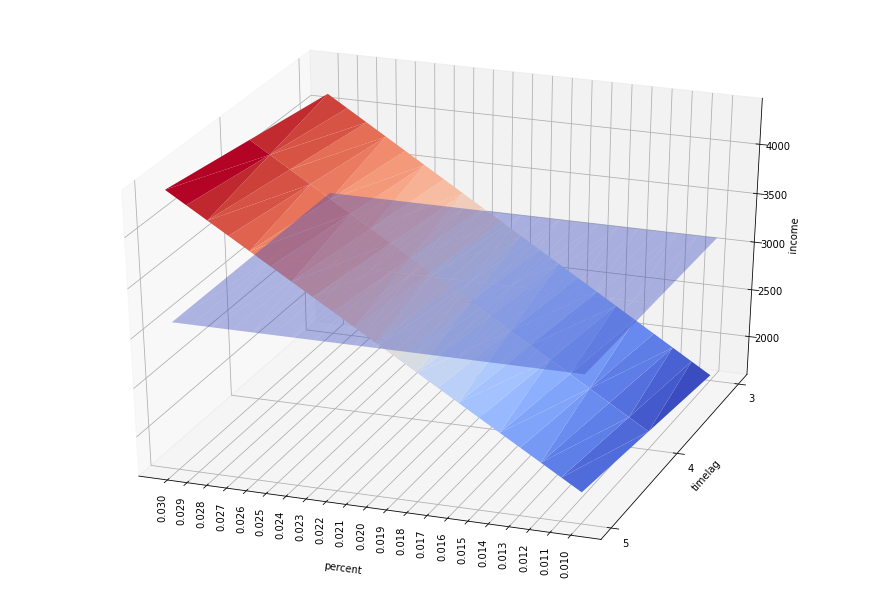

In [65]:
# plot using df

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf(df.percent_z, df.timelag, df.zi_income_yr, cmap=cm.coolwarm, linewidth=0.2)
ax.plot_trisurf(df.percent_z, df.timelag, df.expend_non_zicont_yr, linewidth=0.2, alpha=0.4, cmap=cm.coolwarm)

ax.set_xlabel('percent')
ax.set_ylabel('timelag')
ax.set_yticks(list(TIMELAGS))
ax.set_zlabel('income')
plt.xticks(percent_z_range, rotation='vertical')
ax.xaxis.labelpad = 30

ax.view_init(30, 110)
F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*2, Size[1]*2, forward=True) # Set forward to True to resize window along with plot in figure.

plt.show()

The below graph gives a less pretty but more accurate representation of our income function. If the income function exceeds the  

<ipython-input-66-18c5bb30c115>:18: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surfA_bottom = ax.plot_surface(X, Y, np.where(Z<=M,Z, np.nan),
<ipython-input-66-18c5bb30c115>:23: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surfA_top = ax.plot_surface(X, Y, np.where(Z>=M,Z, np.nan),


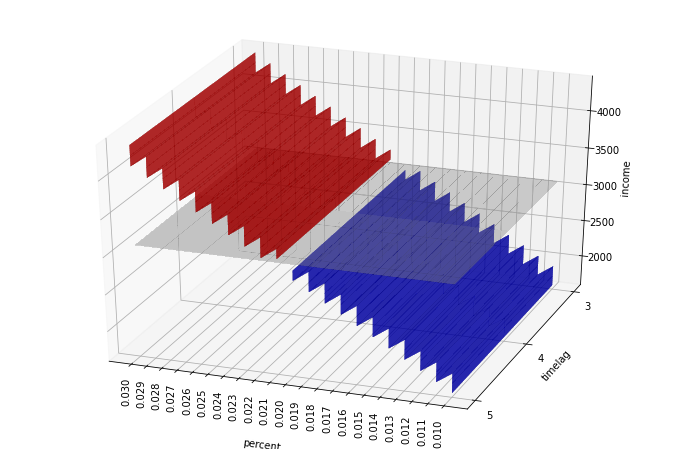

In [66]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.array(df.percent_z)
y = np.array(df.timelag)

X, Y = np.meshgrid(x, y)

# 2d income data
zs = np.array([d['zi_income_yr'] for d in sims_dics] * len(x))
Z = zs.reshape(X.shape)

# 2d enxpenditure data
ms = np.array([d['expend_non_zicont_yr'] for d in sims_dics] * len(x))
M = ms.reshape(X.shape)


surfA_bottom = ax.plot_surface(X, Y, np.where(Z<=M,Z, np.nan),
                               rstride=1, cstride=1, color='b', alpha=0.04, linewidth=0)

surfB = ax.plot_surface(X, Y, M, rstride=1, cstride=1, color='w', alpha=0.01, linewidth=1)

surfA_top = ax.plot_surface(X, Y, np.where(Z>=M,Z, np.nan),
                            rstride=1, cstride=1, color='r', alpha=0.04,linewidth=0)


ax.set_xlabel('percent')
ax.set_ylabel('timelag')
ax.set_yticks(list(TIMELAGS))
ax.set_zlabel('income')
plt.xticks(percent_z_range, rotation='vertical')
ax.xaxis.labelpad = 30

ax.view_init(30, 110)
F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*2, Size[1]*2, forward=True) # Set forward to True to resize window along with plot in figure.

plt.show()